# Milestone 3

## Zamiana zmiennych kategorycznych

Po konsultacjach zdecydowaliśmy się pogrupować zmienną 'Branch' w trzy grupy, ze względu na medianę dochodów w danych miastach zgodnie z danymi ze strony [U.S. Census Bureau](https://www.census.gov/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

df = pd.read_csv("data/banking_dataset.csv", sep=";")

X_dev, X_val = train_test_split(df, test_size=0.1, random_state=42)

X_val.to_csv("data/banking_dataset_val.csv", index=False)
X_dev.to_csv("data/banking_dataset_dev.csv", index=False)

df = X_dev

df = df.drop(['Account ID', 'Customer Name'], axis = 1)
df['Transaction Amount'] = df['Transaction Amount'].str.replace(',', '.').astype(float)
df['Account Balance'] = df['Account Balance'].str.replace(',', '.').astype(float)

In [2]:
high_income = ['San Diego']
medium_income = ['Los Angeles', 'New York', 'Phoenix', 'Chicago']
low_income = ['San Antonio', 'Houston', 'Philadelphia']

def classify_income(city):
    if city in high_income:
        return 'High'
    elif city in medium_income:
        return 'Medium'
    elif city in low_income:
        return 'Low'
    else:
        return 'Unknown'

In [3]:
df['Income_Level'] = df['Branch'].apply(classify_income)

In [4]:
df['Income_Level'].value_counts()

Income_Level
Medium    4541
Low       3400
High      1059
Name: count, dtype: int64

In [5]:
df['Activity_Ratio'] = df['Account Balance'] / (df['Transaction Amount'] + 1)

In [6]:
df = df.drop('Branch', axis=1)
df.head()

Account Type Transaction Type  Transaction Amount  Account Balance  \
4896  Recurring Deposit            Debit             1950.34         68355.08   
4782            Current            Debit             1096.73         23491.31   
1496  Recurring Deposit           Credit             1523.12          9303.10   
1957      Fixed Deposit            Debit             1452.95         43751.88   
9171            Savings            Debit             4170.57         26441.98   

     Currency Income_Level  Activity_Ratio  
4896      USD       Medium       35.029815  
4782      EUR       Medium       21.399898  
1496      JPY          Low        6.103916  
1957      JPY       Medium       30.091736  
9171      INR       Medium        6.338616

Pomiędzy zmiennymi kategorycznymi liczymy współczynnik V Cramera. Dla porównania zmiennych numerycznych zwykła korelacja. Dla kategoryczna vs numeryczna przeprowadzimy analizę wariancji (ANOVA) poniżej

In [7]:
from scipy.stats import chi2_contingency

# Example: Assuming df contains both categorical and numerical variables
categorical_vars = ['Account Type', 'Transaction Type', 'Currency', 'Income_Level']
numeric_vars = ['Transaction Amount', 'Account Balance', 'Activity_Ratio']

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

labels = numeric_vars + categorical_vars
matrix = pd.DataFrame(index=labels, columns=labels)

for i in labels:
    for j in labels:
        if i in numeric_vars and j in numeric_vars:
            corr = df[i].corr(df[j])
        elif i in categorical_vars and j in categorical_vars:
            corr = cramers_v(df[i], df[j])
        elif i in categorical_vars and j in numeric_vars:
            corr = 0
        elif i in numeric_vars and j in categorical_vars:
            corr = 0
        else:
            corr = np.nan
        matrix.loc[i, j] = round(corr, 3)

matrix = matrix.astype(float)

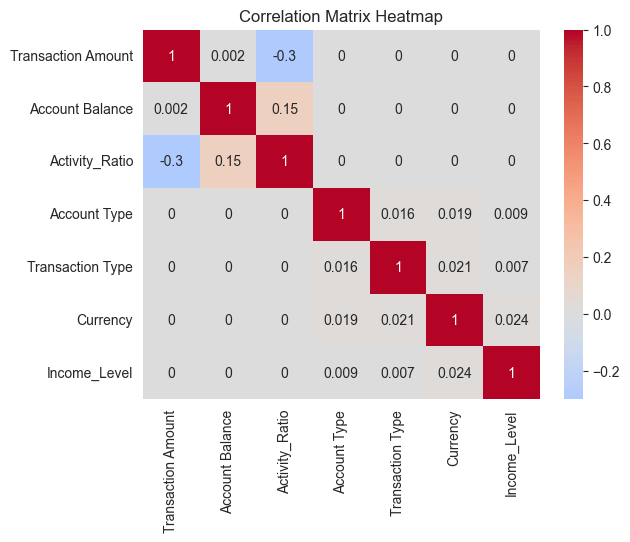

In [8]:
sns.heatmap(matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [9]:
from scipy.stats import f_oneway

def anova(numerical_var):

    data = df.copy()

    anova_results = {}

    for categorical_var in ['Account Type', 'Income_Level', 'Transaction Type', 'Currency']:

        groups = data[categorical_var].unique()

        group_data = [data[data[categorical_var] == group][numerical_var] for group in groups]

        anova_result = f_oneway(*group_data)

        anova_results[categorical_var] = {
            'F-statistic': anova_result.statistic,
            'p-value': anova_result.pvalue
        }

    return anova_results

In [10]:
anova('Transaction Amount')

{'Account Type': {'F-statistic': np.float64(0.19688451747824848),
  'p-value': np.float64(0.8985655898875695)},
 'Income_Level': {'F-statistic': np.float64(0.29215867619869945),
  'p-value': np.float64(0.746657134354542)},
 'Transaction Type': {'F-statistic': np.float64(0.01872281000641237),
  'p-value': np.float64(0.8911671883468454)},
 'Currency': {'F-statistic': np.float64(0.6937568611112611),
  'p-value': np.float64(0.5961717708406151)}}

In [11]:
anova('Account Balance')

{'Account Type': {'F-statistic': np.float64(0.3887267339162903),
  'p-value': np.float64(0.7611291823350348)},
 'Income_Level': {'F-statistic': np.float64(1.0482743365494533),
  'p-value': np.float64(0.35058495585577215)},
 'Transaction Type': {'F-statistic': np.float64(0.5095799829633086),
  'p-value': np.float64(0.4753392501894874)},
 'Currency': {'F-statistic': np.float64(0.3293352320934427),
  'p-value': np.float64(0.8584180750400383)}}

In [12]:
anova('Activity_Ratio')

{'Account Type': {'F-statistic': np.float64(0.15390397564872396),
  'p-value': np.float64(0.9272159439782157)},
 'Income_Level': {'F-statistic': np.float64(0.238849001954095),
  'p-value': np.float64(0.7875387829491383)},
 'Transaction Type': {'F-statistic': np.float64(2.1987291427415996),
  'p-value': np.float64(0.13815959352454996)},
 'Currency': {'F-statistic': np.float64(0.6227282374440759),
  'p-value': np.float64(0.6462758879354278)}}

Nie możemy stwierdzić, aby podział na grupy przez zmienne kategoryczne wpływał na średnie wartości zmiennych numerycznych.

## Dalsze porównania metod klastrowania oraz metody wizualizacji

Pozbywamy się Branch (już usunięta wyżej) na rzecz zmiennej Income_Level, oraz zmiennej Currency ponieważ wartości numeryczne są w dolarach (tak mówi autor ramki danych). Bardziej niż wartość transakcji interesuje nas skala tej transakcji względem balansu na koncie. Dlatego bierzemy activity ratio.

In [13]:
df = df.drop(['Currency', 'Transaction Amount'], axis=1)
df.head()

Account Type Transaction Type  Account Balance Income_Level  \
4896  Recurring Deposit            Debit         68355.08       Medium   
4782            Current            Debit         23491.31       Medium   
1496  Recurring Deposit           Credit          9303.10          Low   
1957      Fixed Deposit            Debit         43751.88       Medium   
9171            Savings            Debit         26441.98       Medium   

      Activity_Ratio  
4896       35.029815  
4782       21.399898  
1496        6.103916  
1957       30.091736  
9171        6.338616

In [14]:
df.shape

(9000, 5)

In [15]:
from sklearn.preprocessing import LabelEncoder

df_le = df.copy()

le = LabelEncoder()
encoding_map = {'Low': 0, 'Medium': 1, 'High': 2}

df_le['Account Type'] = le.fit_transform(df_le['Account Type'])
df_le['Transaction Type'] = le.fit_transform(df_le['Transaction Type'])
df_le['Income_Level'] = df_le['Income_Level'].map(encoding_map)

In [16]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df1 = df_le.copy()

X = df1.values

X_minmax = MinMaxScaler().fit_transform(X)
X_standard = StandardScaler().fit_transform(X)

In [17]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df1 = df_le.copy()

X = df1.values

# t-SNE dla nieprzekształconych danych
tsne_raw = TSNE(n_components=2, random_state=42, metric='manhattan')
X_tsne_raw = tsne_raw.fit_transform(X)

# 2. t-SNE dla danych po normalizacji
X_minmax = MinMaxScaler().fit_transform(X)
X_tsne_minmax = TSNE(n_components=2, random_state=42, metric='manhattan').fit_transform(X_minmax)

# 3. t-SNE dla danych po standaryzacji
X_standard = StandardScaler().fit_transform(X)
X_tsne_standard = TSNE(n_components=2, random_state=42, metric='manhattan').fit_transform(X_standard)

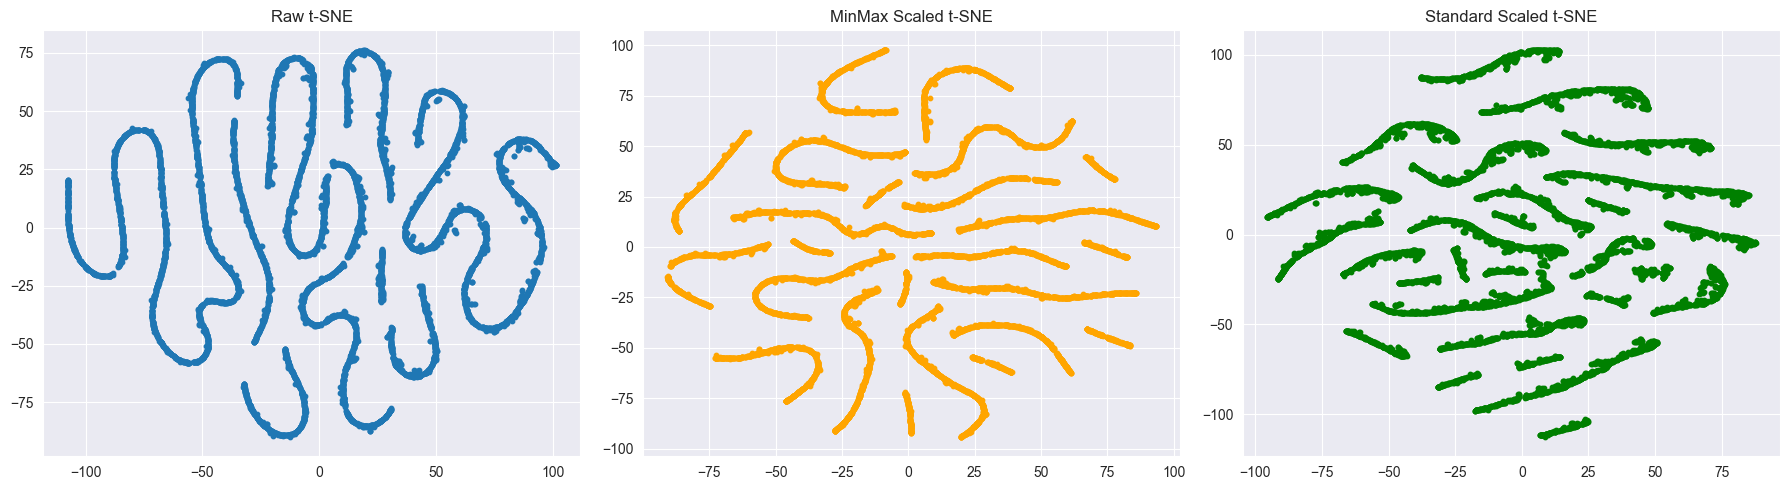

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_tsne_raw[:, 0], X_tsne_raw[:, 1], s=10)
axes[0].set_title('Raw t-SNE')

axes[1].scatter(X_tsne_minmax[:, 0], X_tsne_minmax[:, 1], s=10, c='orange')
axes[1].set_title('MinMax Scaled t-SNE')

axes[2].scatter(X_tsne_standard[:, 0], X_tsne_standard[:, 1], s=10, c='green')
axes[2].set_title('Standard Scaled t-SNE')

plt.tight_layout()
plt.show()

In [19]:
from sklearn.cluster import DBSCAN
dbscan_minmax = DBSCAN(eps=0.5, min_samples=10, metric='manhattan').fit(X_minmax)

In [20]:
n_clusters = len(set(dbscan_minmax.labels_)) - (1 if -1 in dbscan_minmax.labels_ else 0)

print(f"Number of clusters: {n_clusters}")

Number of clusters: 6


In [21]:
dbscan_standard = DBSCAN(eps=0.5, min_samples=10, metric='manhattan').fit(X_standard)

In [22]:
n_clusters = len(set(dbscan_standard.labels_)) - (1 if -1 in dbscan_standard.labels_ else 0)

print(f"Number of clusters: {n_clusters}")

Number of clusters: 24


In [23]:
tsne_3d = TSNE(n_components=3, random_state=42, metric='manhattan')
X_3d_tsne_minmax = tsne_3d.fit_transform(X_minmax)

In [24]:
X_3d_tsne_standard = tsne_3d.fit_transform(X_standard)

In [25]:
import plotly.graph_objects as go
import plotly.express as px

def visualize_clusters_3d(X, labels):
    color_array = np.where(labels == -1, 'black', labels)
    colors = px.colors.qualitative.Light24
    label_colors = [colors[i % len(colors)] if i != -1 else 'black' for i in labels]

    fig = go.Figure(data=[go.Scatter3d(
        x=X[:, 0],
        y=X[:, 1],
        z=X[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=label_colors,
            opacity=0.4,
        )
    )])

    fig.update_layout(
        scene=dict(
            xaxis_title='Component 1',
            yaxis_title='Component 2',
            zaxis_title='Component 3',
            bgcolor='grey',
            xaxis = dict(
                         backgroundcolor="rgb(200, 200, 230)",
                         gridcolor="white",
                         showbackground=True,
                         zerolinecolor="white",),
            yaxis = dict(
                         backgroundcolor="rgb(200, 200, 230)",
                         gridcolor="white",
                         showbackground=True,
                         zerolinecolor="white",),
            zaxis = dict(
                         backgroundcolor="rgb(200, 200, 230)",
                         gridcolor="white",
                         showbackground=True,
                         zerolinecolor="white",)
        ),
        margin=dict(l=0, r=0, b=0, t=0)
    )

    fig.show()

In [26]:
visualize_clusters_3d(X_3d_tsne_minmax, dbscan_minmax.labels_)

In [27]:
visualize_clusters_3d(X_3d_tsne_standard, dbscan_standard.labels_)

In [28]:
import umap.umap_ as umap

X_3d_umap_minmax = umap.UMAP(random_state=42, n_components=3, metric='manhattan').fit_transform(X_minmax)

C:\Users\Wojtek\Documents\ML\klasteryzacja\.venv1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

C:\Users\Wojtek\Documents\ML\klasteryzacja\.venv1\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Wojtek\Documents\ML\klasteryzacja\.venv1\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [29]:
visualize_clusters_3d(X_3d_umap_minmax, dbscan_minmax.labels_)

In [30]:
X_3d_umap_standard = umap.UMAP(random_state=42, n_components=3, metric='manhattan').fit_transform(X_standard)

C:\Users\Wojtek\Documents\ML\klasteryzacja\.venv1\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Wojtek\Documents\ML\klasteryzacja\.venv1\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [31]:
visualize_clusters_3d(X_3d_umap_standard, dbscan_standard.labels_)

### Metoda K-średnich

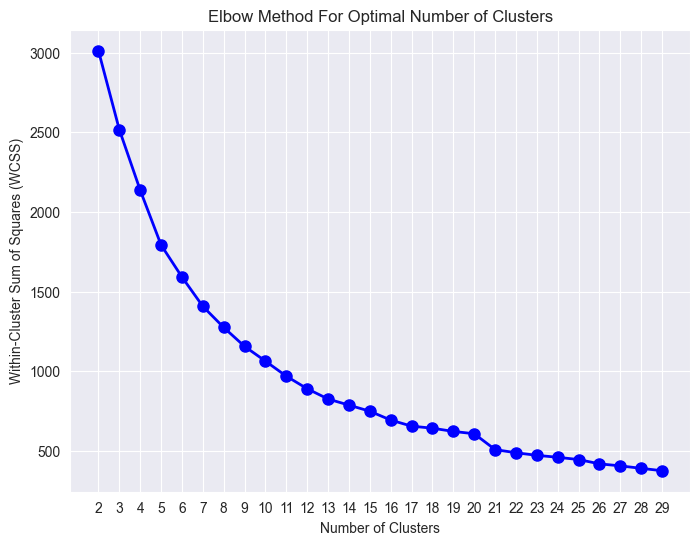

In [32]:
from sklearn.cluster import KMeans

range_n_clusters = range(2, 30)

wcss = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_minmax)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, wcss, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

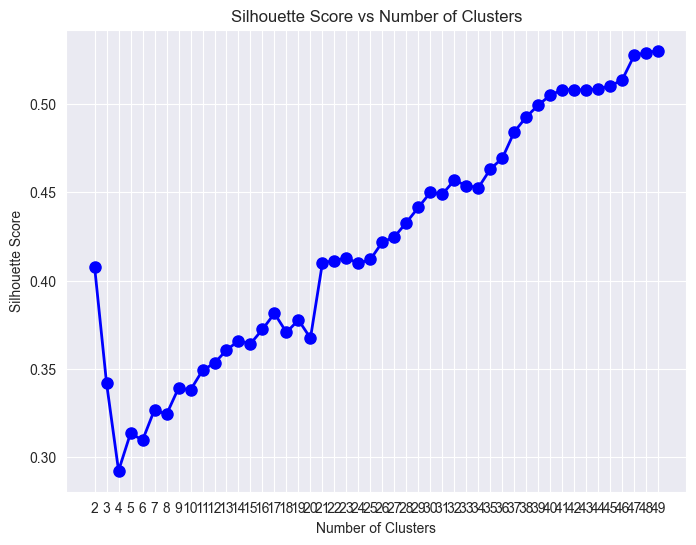

In [33]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

range_n_clusters = range(2, 50)

silhouette_scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_minmax)
    silhouette_avg = silhouette_score(X_minmax, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

In [38]:
kmeans21_minmax = KMeans(n_clusters=21, random_state=42).fit(X_minmax)

In [39]:
visualize_clusters_3d(X_3d_tsne_minmax, kmeans21_minmax.labels_)

In [40]:
visualize_clusters_3d(X_3d_umap_minmax, kmeans21_minmax.labels_)

In [41]:
kmeans21_standard = KMeans(n_clusters=21, random_state=42).fit(X_standard)

In [42]:
visualize_clusters_3d(X_3d_tsne_standard, kmeans21_standard.labels_)

In [43]:
visualize_clusters_3d(X_3d_umap_standard, kmeans21_standard.labels_)

### Agglomerative clustering

In [44]:
from sklearn.cluster import AgglomerativeClustering

In [45]:
agglmer_comp = AgglomerativeClustering(n_clusters=24, linkage='complete', metric='manhattan').fit(X_minmax)

In [46]:
visualize_clusters_3d(X_3d_umap_minmax, agglmer_comp.labels_)

In [47]:
agglomer_avg = AgglomerativeClustering(n_clusters=24, linkage='average', metric='manhattan').fit(X_minmax)

In [48]:
visualize_clusters_3d(X_3d_umap_minmax, agglomer_avg.labels_)

In [49]:
agglomer_sngl = AgglomerativeClustering(n_clusters=24, linkage='single', metric='manhattan').fit(X_minmax)

In [50]:
visualize_clusters_3d(X_3d_umap_minmax, agglomer_sngl.labels_)

## Miary klastrów

Jako miarę jakości postanowiliśmy wybrać Dunn Index. Chcemy dostać więcej niż dwa klastry

In [51]:
from scipy.spatial.distance import cdist

def dunn_index(X, labels, metric='euclidean'):

    mask = labels != -1
    X = X[mask]
    labels = labels[mask]

    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    if n_clusters < 2:
        return np.nan  # Not enough clusters

    # Intra-cluster distances
    intra_dists = []
    for k in unique_labels:
        cluster_k = X[labels == k]
        if len(cluster_k) > 1:
            dist_matrix = cdist(cluster_k, cluster_k, metric=metric)
            intra_dists.append(np.max(dist_matrix))
        else:
            intra_dists.append(0)

    max_intra = np.max(intra_dists)

    # Inter-cluster distances
    inter_dists = []
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            cluster_i = X[labels == unique_labels[i]]
            cluster_j = X[labels == unique_labels[j]]
            dist_matrix = cdist(cluster_i, cluster_j, metric=metric)
            inter_dists.append(np.min(dist_matrix))

    min_inter = np.min(inter_dists)

    if max_intra == 0:
        return np.inf
    return min_inter / max_intra

In [52]:
clusters = [dbscan_minmax, kmeans21_minmax, agglomer_sngl, agglomer_avg, agglmer_comp]

for i in clusters:
    print(f"{i} Dunn index: {dunn_index(X_minmax, i.labels_, metric='cityblock')}")

DBSCAN(metric='manhattan', min_samples=10) Dunn index: 0.21451348106345156
KMeans(n_clusters=21, random_state=42) Dunn index: 0.001151737348553427
AgglomerativeClustering(linkage='single', metric='manhattan', n_clusters=24) Dunn index: 0.1447591868582537
AgglomerativeClustering(linkage='average', metric='manhattan', n_clusters=24) Dunn index: 0.006107072351017142
AgglomerativeClustering(linkage='complete', metric='manhattan', n_clusters=24) Dunn index: 0.0034123610769092893


In [53]:
clusters = [dbscan_standard, kmeans21_standard]

for i in clusters:
    print(f"{i} Dunn index: {dunn_index(X_standard, i.labels_, metric='cityblock')}")

DBSCAN(metric='manhattan', min_samples=10) Dunn index: 0.1943473591922805
KMeans(n_clusters=21, random_state=42) Dunn index: 0.0011011807772984936


### Dostrajanie modeli

#### DBSCAN

In [54]:
param_grid = {'eps': np.linspace(0.1, 1., num=10),
              'min_samples': range(1,10),
}

best_score = -1
best_params = {}

for eps in param_grid['eps']:
    for min_samples in param_grid['min_samples']:

        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='manhattan')
        labels = dbscan.fit_predict(X_minmax)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters > 2:
            score = dunn_index(X_minmax, labels, metric='cityblock')

            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}


print(best_params)
print(best_score)

{'eps': np.float64(0.1), 'min_samples': 4}
0.2996695934993307


In [55]:
param_grid = {'eps': np.linspace(0.01, 0.1, num=10),
              'min_samples': range(1,10),
}

best_score = -1
best_params = {}

for eps in param_grid['eps']:
    for min_samples in param_grid['min_samples']:

        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='manhattan')
        labels = dbscan.fit_predict(X_minmax)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters > 2:
            score = dunn_index(X_minmax, labels, metric='cityblock')

            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}


print(best_params)
print(best_score)

{'eps': np.float64(0.07), 'min_samples': 4}
0.30942861368117514


### K-średnich

In [56]:
param_grid = {'n_clusters': range(3,30),
              'init': ['k-means++', 'random']}

best_score = -1
best_params = {}

for n_clusters in param_grid['n_clusters']:
    for init in param_grid['init']:

        kmeans = KMeans(n_clusters=n_clusters, init=init, random_state=42)
        labels = kmeans.fit_predict(X_minmax)

        score = dunn_index(X_minmax, labels, metric='cityblock')

        if score > best_score:
            best_score = score
            best_params = {'n_clusters': n_clusters, 'init': init}


print(best_params)
print(best_score)

{'n_clusters': 6, 'init': 'random'}
0.12147506575129147


### Agglomerative

In [57]:
param_grid = {'n_clusters': range(3,30),
              'linkage': ['single']}

best_score = -1
best_params = {}

for n_clusters in param_grid['n_clusters']:
    for linkage in param_grid['linkage']:

        agglmer = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric='manhattan')
        labels = agglmer.fit_predict(X_minmax)

        score = dunn_index(X_minmax, labels, metric='cityblock')

        if score > best_score:
            best_score = score
            best_params = {'n_clusters': n_clusters, 'linkage': linkage}


print(best_params)
print(best_score)

{'n_clusters': 3, 'linkage': 'single'}
0.2561926016063541


In [58]:
param_grid = {'n_clusters': range(10,30),
              'linkage': ['single']}

best_score = -1
best_params = {}

for n_clusters in param_grid['n_clusters']:
    for linkage in param_grid['linkage']:

        agglmer = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric='manhattan')
        labels = agglmer.fit_predict(X_minmax)

        score = dunn_index(X_minmax, labels, metric='cityblock')

        if score > best_score:
            best_score = score
            best_params = {'n_clusters': n_clusters, 'linkage': linkage}


print(best_params)
print(best_score)

{'n_clusters': 29, 'linkage': 'single'}
0.21454140730321464


In [59]:
scores = []
n_clusters = []

for i in range(3,60):
    labels = AgglomerativeClustering(n_clusters=i, linkage='single', metric='manhattan').fit_predict(X_minmax)

    n_clusters.append(i)
    scores.append(dunn_index(X_minmax, labels, metric='cityblock'))

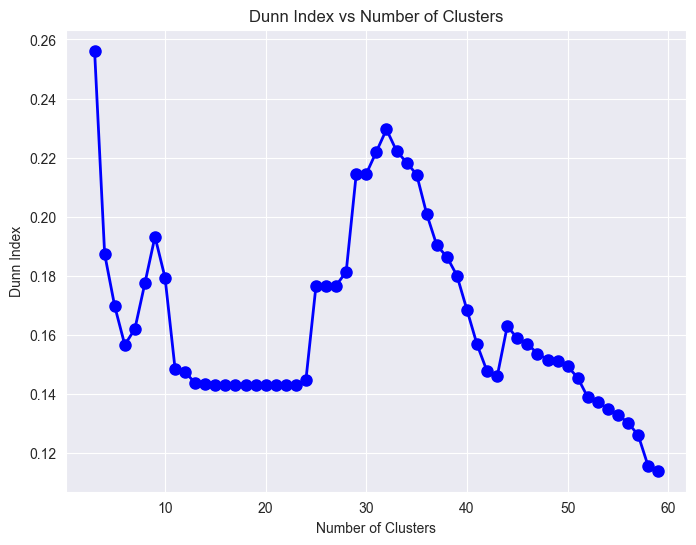

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(n_clusters, scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters')
plt.ylabel('Dunn Index')
plt.title('Dunn Index vs Number of Clusters')
plt.grid(True)
plt.show()

3 oraz 32

### HDBSCAN

In [61]:
from sklearn.cluster import HDBSCAN

param_grid = {'min_cluster_size': range(3,11),
              'cluster_selection_epsilon': [0.0,0.1,0.2]}

best_score = -1
best_params = {}

for min_cluster_size in param_grid['min_cluster_size']:
    for cluster_selection_epsilon in param_grid['cluster_selection_epsilon']:

        hdbscan = HDBSCAN(min_cluster_size=min_cluster_size, cluster_selection_epsilon=cluster_selection_epsilon, metric='manhattan')
        labels = hdbscan.fit_predict(X_minmax)

        score = dunn_index(X_minmax, labels, metric='cityblock')

        if score > best_score:
            best_score = score
            best_params = {'min_cluster_size': min_cluster_size, 'cluster_selection_epsilon': cluster_selection_epsilon}


print(best_params)
print(best_score)

{'min_cluster_size': 8, 'cluster_selection_epsilon': 0.1}
0.26425891532128354


In [62]:
visualize_clusters_3d(X_3d_umap_minmax, HDBSCAN(min_cluster_size=8, cluster_selection_epsilon=0.1).fit_predict(X_minmax))

Nie jest to lepsze od DBSCAN

In [63]:
visualize_clusters_3d(X_3d_umap_minmax, DBSCAN(eps=0.07, min_samples=4, metric='manhattan').fit_predict(X_minmax))

## Interpretacja klastrów dla modelu DBSCAN

In [64]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=0.07, min_samples=4, metric='manhattan').fit(X_minmax)

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_minmax, model.labels_, test_size=0.1, random_state=42)

In [66]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(random_state=42)

rnd_clf.fit(X_train, y_train)

print(rnd_clf.feature_importances_)
print(df_le.columns)

[0.45478768 0.17388472 0.01441858 0.33003298 0.02687604]
Index(['Account Type', 'Transaction Type', 'Account Balance', 'Income_Level',
       'Activity_Ratio'],
      dtype='object')


In [67]:
import shap

explainer = shap.Explainer(rnd_clf, X_train)
shap_values = explainer(X_test, check_additivity=False)

100%|===================| 22433/22500 [01:57<00:00]        

In [68]:
shap_mean = np.abs(shap_values.values[:, :, 0]).mean(axis=0)

shap_df = pd.DataFrame({
    'Feature': df_le.columns,
    'Mean_SHAP': shap_mean
}).sort_values(by='Mean_SHAP', ascending=False)

shap_df.head(5)

Feature  Mean_SHAP
4    Activity_Ratio   0.009826
3      Income_Level   0.001219
0      Account Type   0.001019
1  Transaction Type   0.000714
2   Account Balance   0.000667

In [69]:
df_labeled = df.copy()

In [70]:
df_labeled['Cluster'] = model.labels_

In [71]:
df_labeled.head(10)

Account Type Transaction Type  Account Balance Income_Level  \
4896  Recurring Deposit            Debit         68355.08       Medium   
4782            Current            Debit         23491.31       Medium   
1496  Recurring Deposit           Credit          9303.10          Low   
1957      Fixed Deposit            Debit         43751.88       Medium   
9171            Savings            Debit         26441.98       Medium   
9745            Current           Credit         67444.23       Medium   
7332      Fixed Deposit           Credit         44663.63          Low   
7949  Recurring Deposit            Debit         75325.42       Medium   
3017            Current           Credit         68981.76         High   
6746  Recurring Deposit           Credit         70582.03       Medium   

      Activity_Ratio  Cluster  
4896       35.029815        0  
4782       21.399898        1  
1496        6.103916        2  
1957       30.091736        3  
9171        6.338616        4  
9745       17.013627        5  
7332       10.473578        6  
7949       19.264124        0  
3017       15.564652        7  
6746       30.941560        8

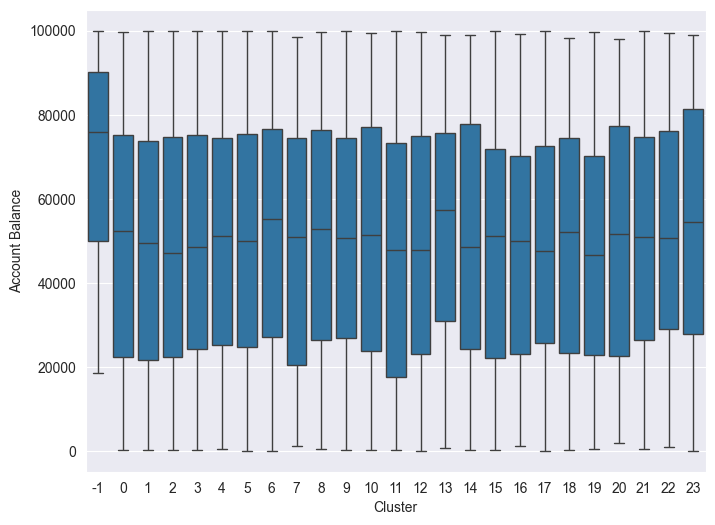

In [72]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='Account Balance', data=df_labeled)
plt.title('')
plt.show()

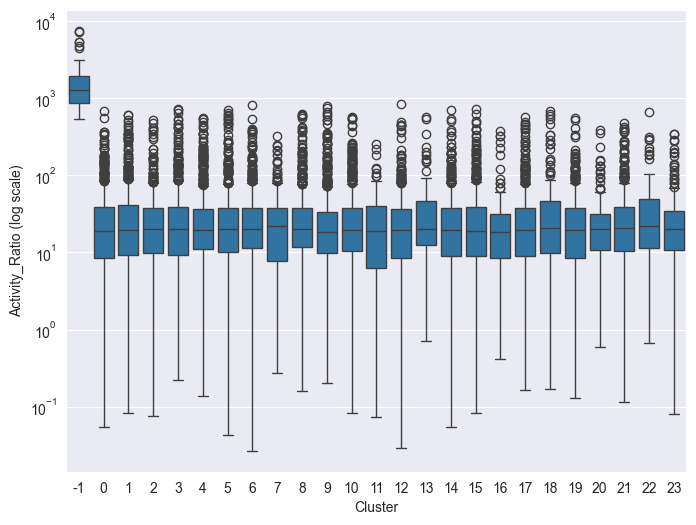

In [73]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='Activity_Ratio', data=df_labeled)
plt.title('')
# plt.xticks(rotation=45)
plt.yscale('log')
plt.ylabel('Activity_Ratio (log scale)')
plt.show()

-1 jest znacznikiem dla transakcji niesklastrowanych. Duża wartość Activity_Ratio wskazuje na małą wartość transakcji w stosunku do salda na koncie.

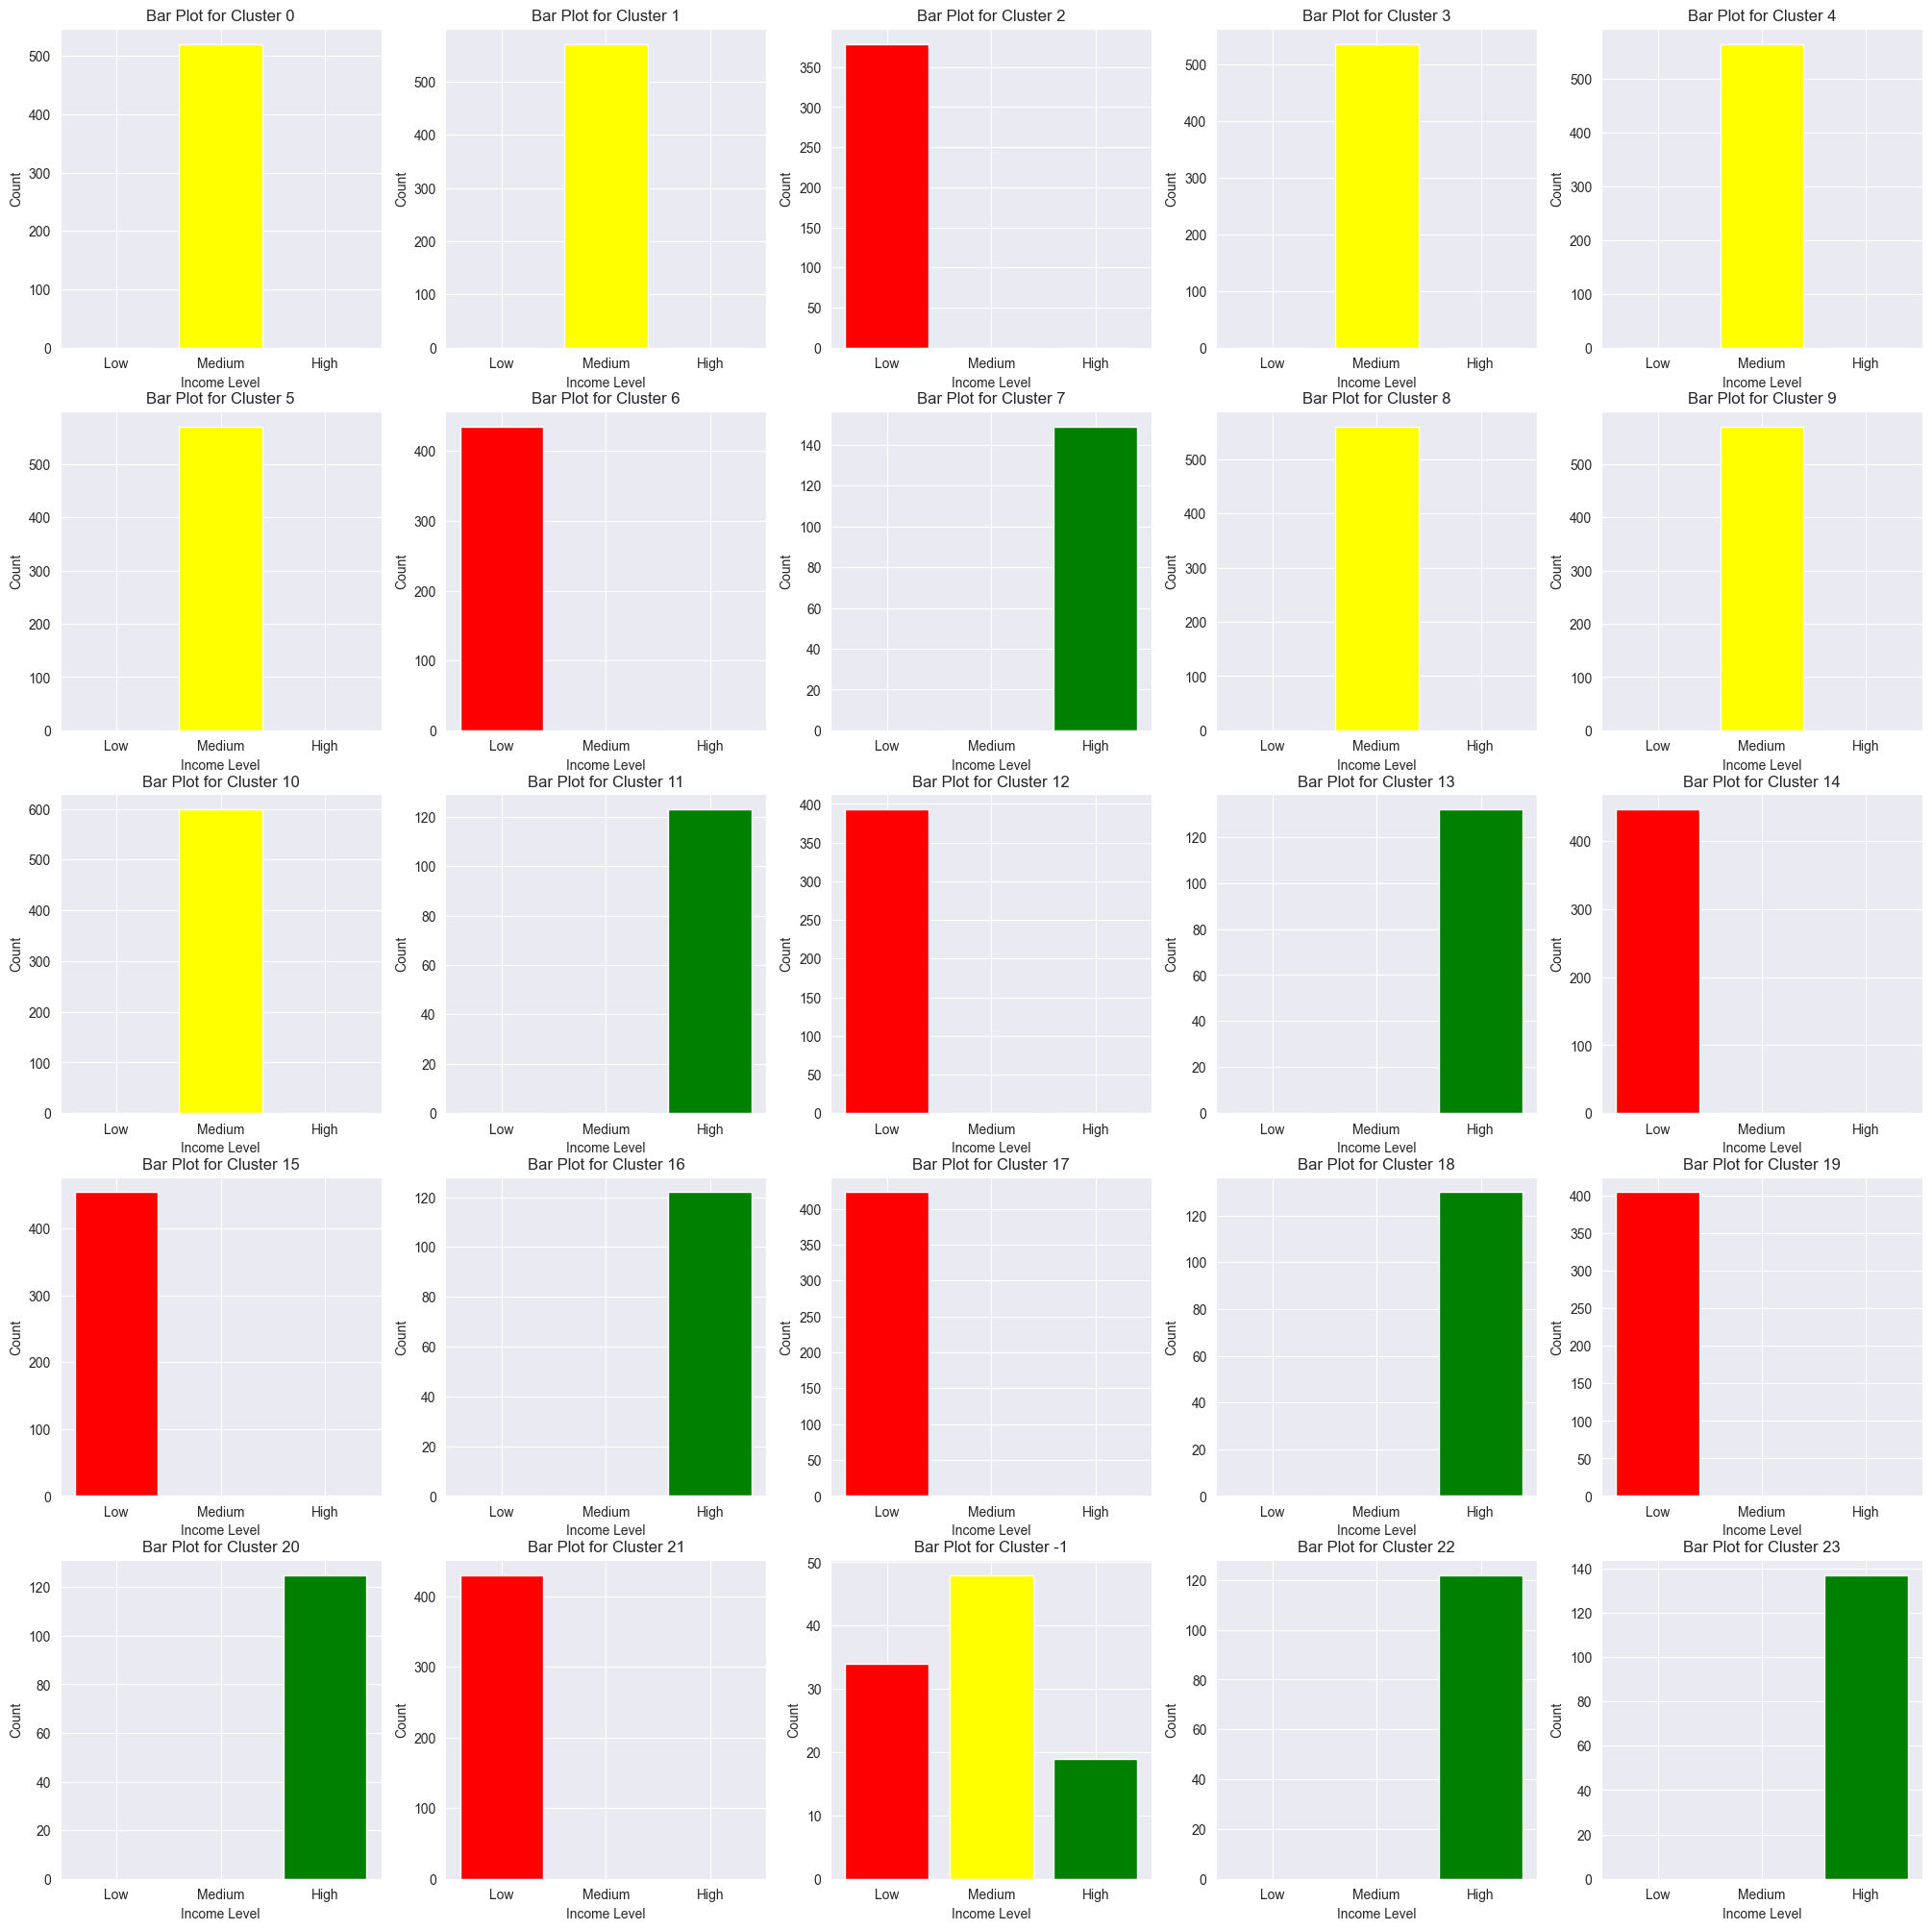

In [74]:
fig, axes = plt.subplots(5, 5, figsize=(25, 25))

axes = axes.ravel()

categories = ['Low', 'Medium', 'High']

category_colors = {
    'Low': 'red',
    'Medium': 'yellow',
    'High': 'green'
}

for i, cluster in enumerate(df_labeled['Cluster'].unique()):
    cluster_data = df_labeled[df_labeled['Cluster'] == cluster]
    category_counts = cluster_data['Income_Level'].value_counts().reindex(categories, fill_value=0)

    # Plot on the appropriate subplot
    bars = axes[i].bar(category_counts.index, category_counts.values, color=[category_colors[cat] for cat in category_counts.index])
    axes[i].set_title(f'Bar Plot for Cluster {cluster}')
    axes[i].set_xlabel('Income Level')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks(category_counts.index)
    axes[i].grid(True)

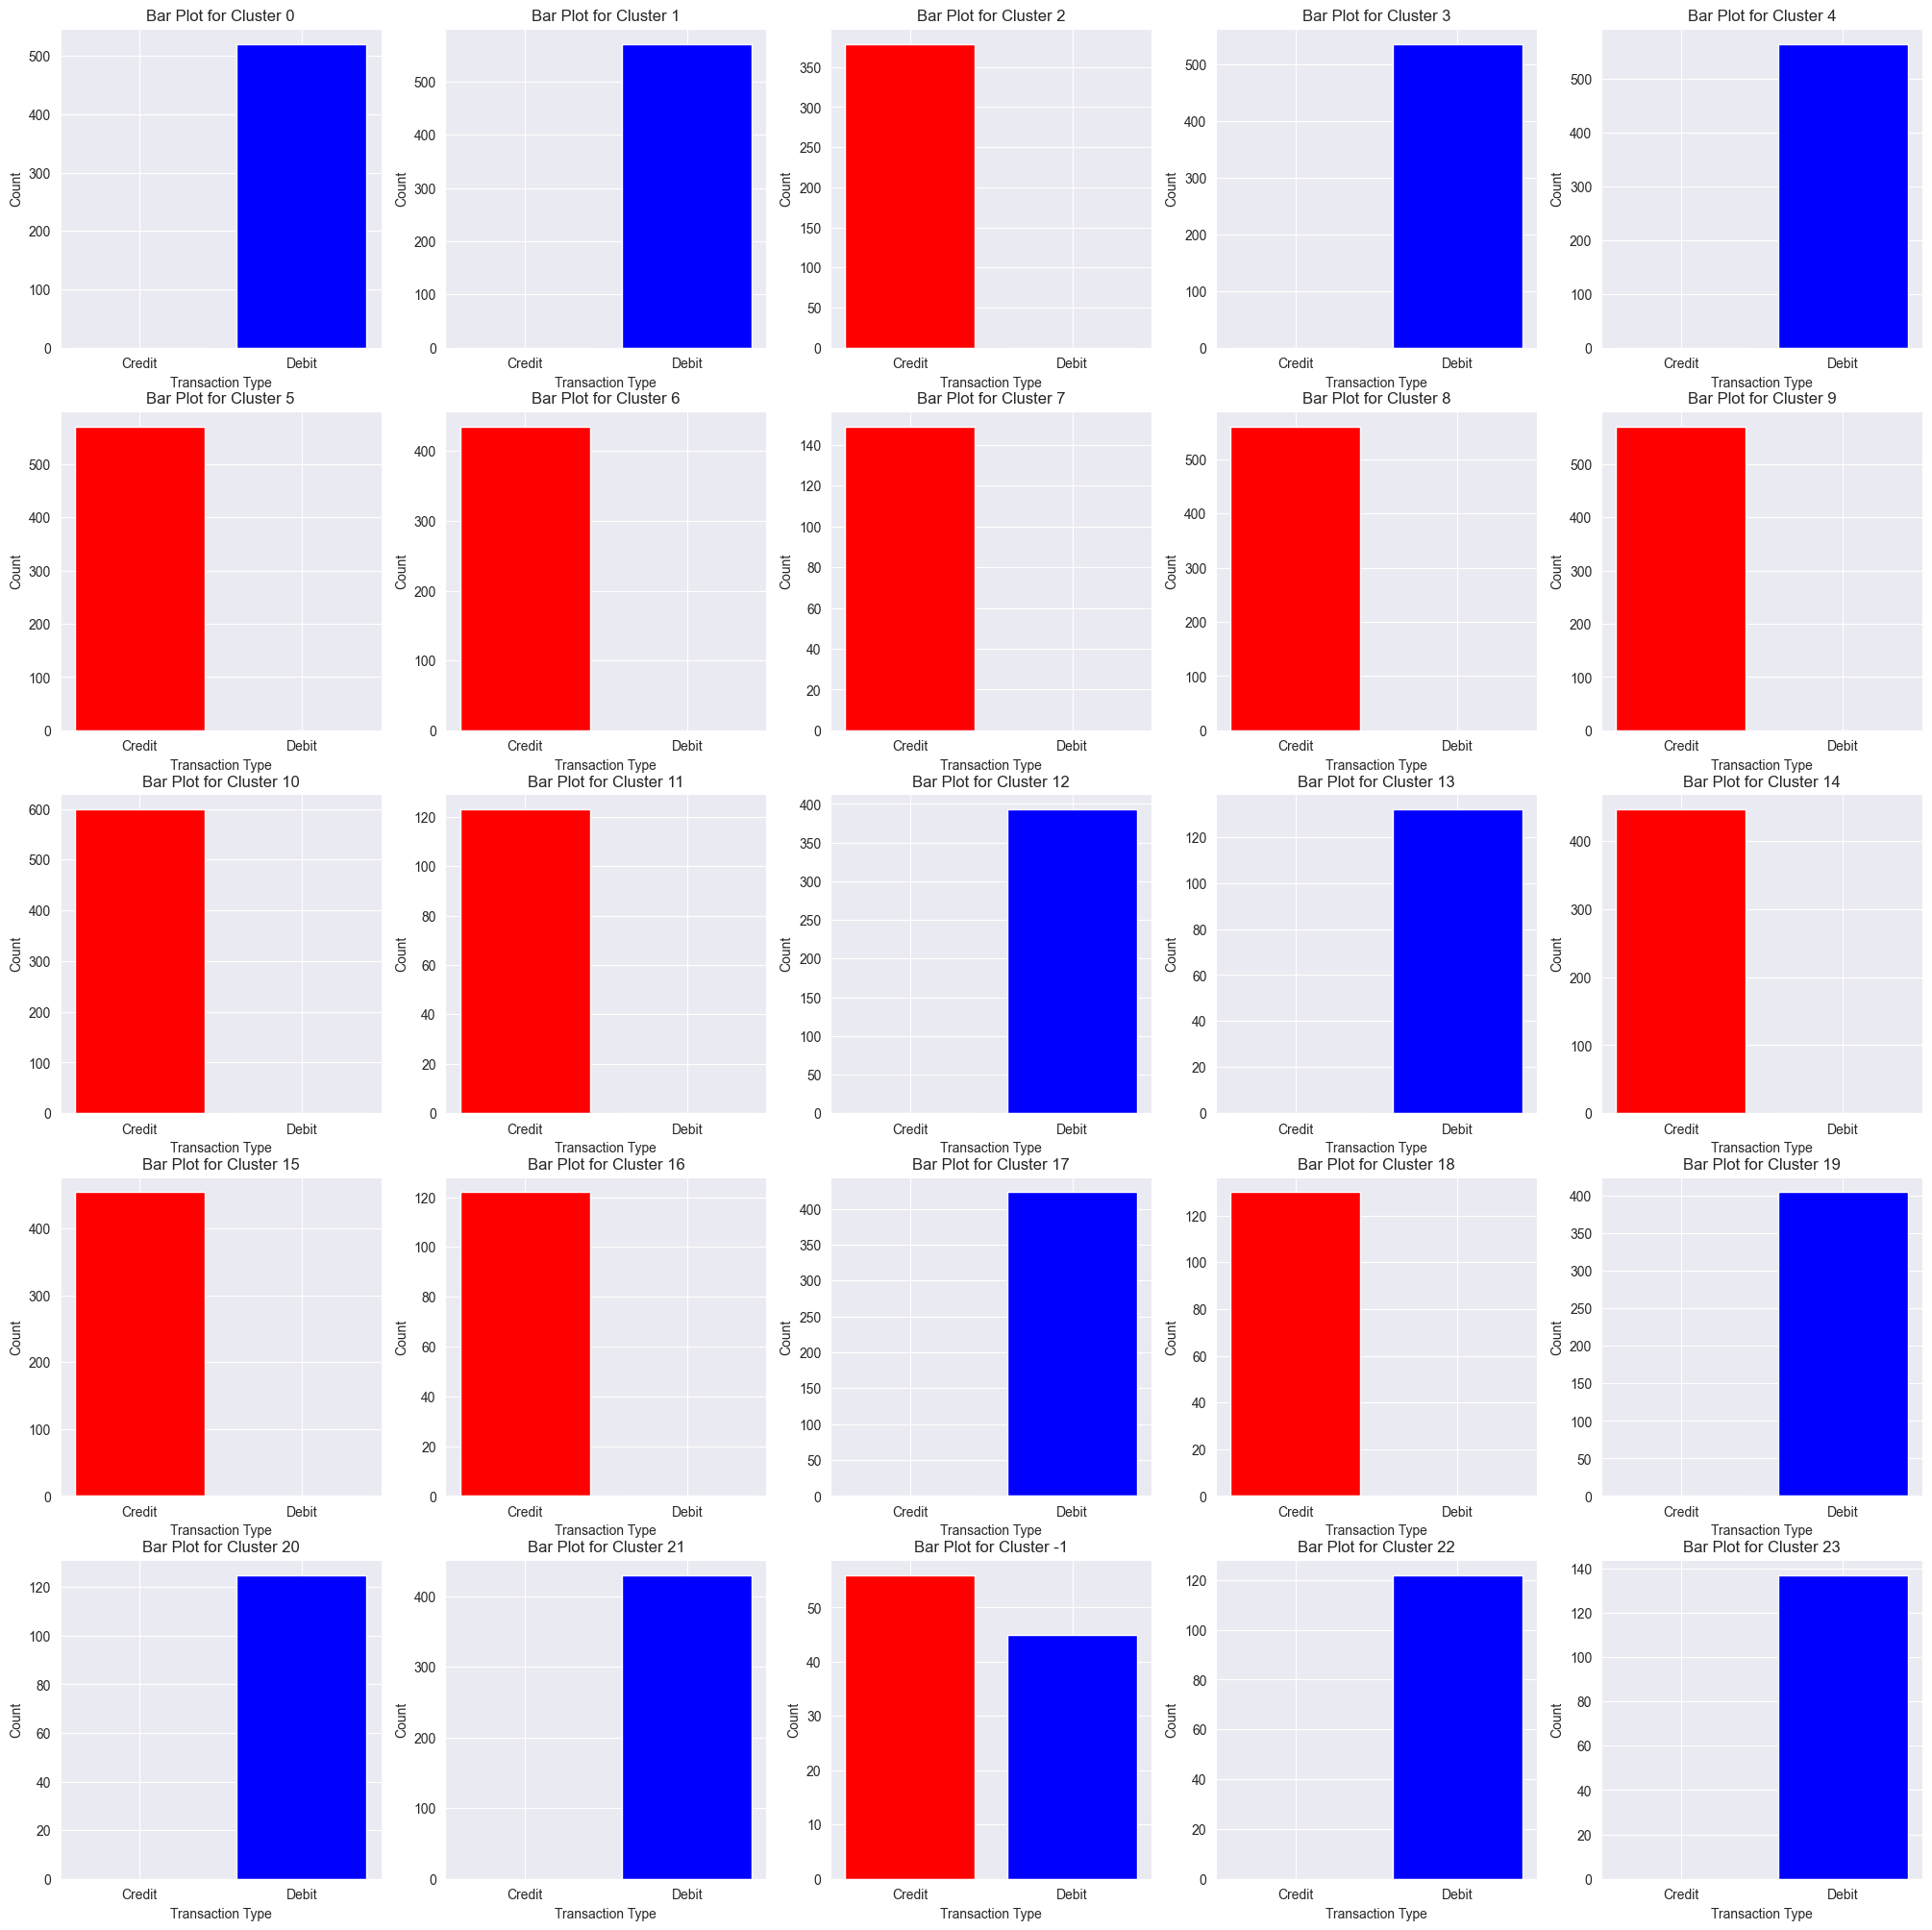

In [75]:
fig, axes = plt.subplots(5, 5, figsize=(25, 25))

axes = axes.ravel()

categories = ['Credit', 'Debit']

category_colors = {
    'Credit': 'red',
    'Debit': 'blue',
}

for i, cluster in enumerate(df_labeled['Cluster'].unique()):
    cluster_data = df_labeled[df_labeled['Cluster'] == cluster]
    category_counts = cluster_data['Transaction Type'].value_counts().reindex(categories, fill_value=0)

    # Plot on the appropriate subplot
    bars = axes[i].bar(category_counts.index, category_counts.values, color=[category_colors[cat] for cat in category_counts.index])
    axes[i].set_title(f'Bar Plot for Cluster {cluster}')
    axes[i].set_xlabel('Transaction Type')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks(category_counts.index)
    axes[i].grid(True)

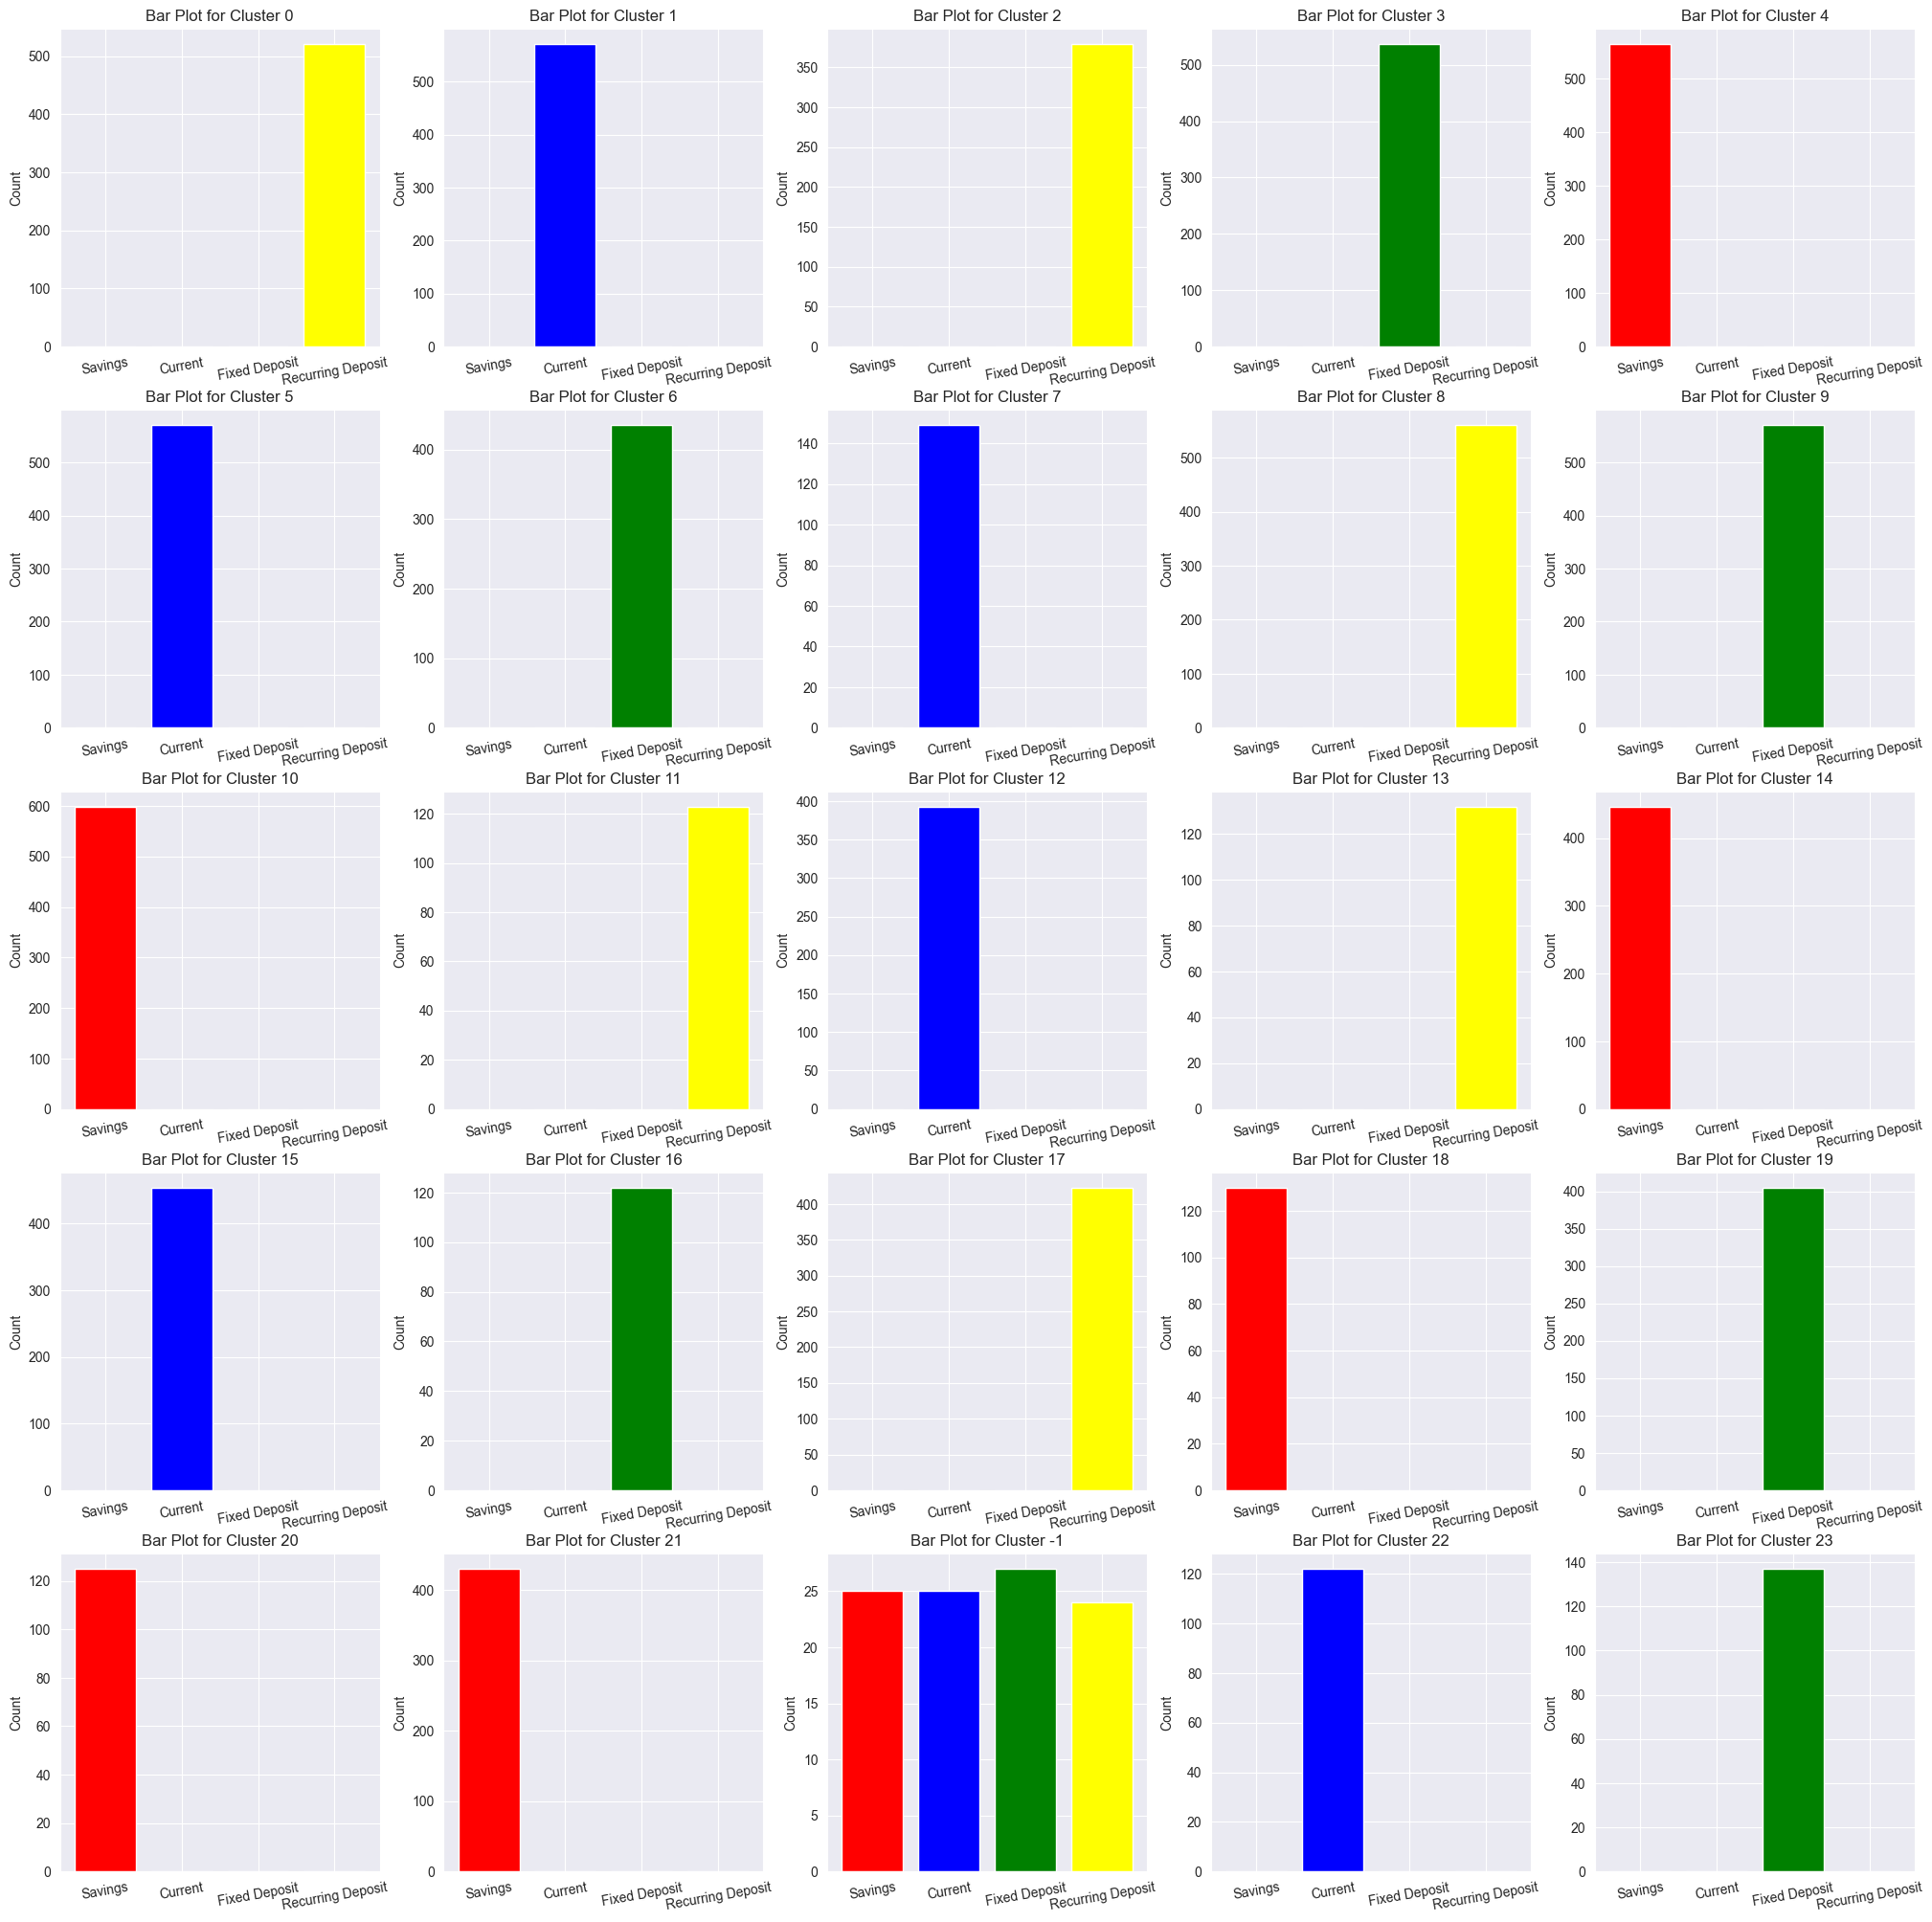

In [76]:
fig, axes = plt.subplots(5, 5, figsize=(25, 25))

axes = axes.ravel()

categories = ['Savings', 'Current', 'Fixed Deposit', 'Recurring Deposit']

category_colors = {
    'Savings': 'red',
    'Current': 'blue',
    'Fixed Deposit': 'green',
    'Recurring Deposit': 'yellow',
}

for i, cluster in enumerate(df_labeled['Cluster'].unique()):
    cluster_data = df_labeled[df_labeled['Cluster'] == cluster]
    category_counts = cluster_data['Account Type'].value_counts().reindex(categories, fill_value=0)

    # Plot on the appropriate subplot
    bars = axes[i].bar(category_counts.index, category_counts.values, color=[category_colors[cat] for cat in category_counts.index])
    axes[i].set_title(f'Bar Plot for Cluster {cluster}')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks(category_counts.index)
    axes[i].set_xticklabels(category_counts.index, rotation=10)
    axes[i].grid(True)

Widzimy, że na dobór do klastrów wpływają przede wszystkim zmienne kategoryczne. Zmienne numeryczne wyłapują jedynie odstające wartości, które nie są wrzucane do żadnego klastra. Takie transakcje mogą zostać potrakotwane jako podejrzane.